In [15]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}
import os, zipfile, io, re, glob
from PIL import Image
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.ndimage.morphology import distance_transform_edt
from skimage.filters import threshold_otsu
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from PHdict import comp_PH,dt
import persim
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
num_cores = multiprocessing.cpu_count()


In [6]:
# load images and database
outdir = "result20210512"
os.makedirs(outdir, exist_ok=True)
distance_transform = False
save_fig = False
dpath = ["gen_img_sample"]
filelist = [glob.glob(os.path.join(dp,"*.jpg")) for dp in dpath]
filelist = sorted(sum(filelist, []))
df_org = []
for fn in filelist:
    img_org = np.array(Image.open(fn))
    ph = comp_PH(img_org)
    df_org.append({'img': img_org, 'ph': ph, 'filename': fn})

df_org = pd.DataFrame(df_org)
print("filenames: ", filelist)
m = float(min([df_org['img'][i].min() for i in range(len(df_org))]))
M = float(max([df_org['img'][i].max() for i in range(len(df_org))]))
print("#samples: ", len(df_org), "resolution: ", df_org['img'][0].shape, "min value: ",m , "max value: ", M)

filenames:  ['gen_img_sample/00000000.jpg', 'gen_img_sample/00000001.jpg', 'gen_img_sample/00000002.jpg', 'gen_img_sample/00000003.jpg', 'gen_img_sample/00000004.jpg', 'gen_img_sample/00000005.jpg', 'gen_img_sample/00000006.jpg', 'gen_img_sample/00000007.jpg', 'gen_img_sample/00000008.jpg', 'gen_img_sample/00000009.jpg', 'gen_img_sample/00000010.jpg', 'gen_img_sample/00000011.jpg', 'gen_img_sample/00000012.jpg', 'gen_img_sample/00000013.jpg', 'gen_img_sample/00000014.jpg', 'gen_img_sample/00000015.jpg', 'gen_img_sample/00000016.jpg', 'gen_img_sample/00000017.jpg', 'gen_img_sample/00000018.jpg', 'gen_img_sample/00000019.jpg', 'gen_img_sample/00000020.jpg']
#samples:  21 resolution:  (256, 256, 3) min value:  0.0 max value:  255.0


In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import manifold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
def plotPD(idx, axis=False):
    n = len(idx)
    for i in range(n):
        pds = df_org.loc[idx[i],'ph']
        for d in [0,1]:
            u = pds[pds[:,0] == d]
            ax = plt.subplot(3,n,i+1+d*n)
            if axis==False:
                ax.axis('off')
            persim.plot_diagrams(u[:,1:3],ax=ax,legend=False, lifetime=True, size=1)

def plotPI(idx):
    n = len(idx)
    for i in range(n):
        for d in [0,1]:
            ax = plt.subplot(3,n,i+1+d*n)
            ax.axis('off')
            u = pims[d][idx[i]]
            pim.plot_image(u, ax=ax)
            #ax.imshow(u)

def plot_features(features, method="PCA", filename=None):
    A=features
    B=features

    if method=="MDS":
        mds = manifold.MDS(n_components=2)
        x_pca = mds.fit(A).transform(B)
    elif method=="TSNE":
        x_pca = manifold.TSNE(n_components=2,perplexity=6).fit_transform(A)  #pplx=6 for group1n2
    elif method=="PCA":
        pca = PCA(n_components=2)
        x_pca = pca.fit(A).transform(B)
        print("Explained variance:", pca.explained_variance_ratio_)
    elif method=="LDA":
        lda = LinearDiscriminantAnalysis()
        x_pca = lda.fit(A, t).transform(B)
    elif method=="UMAP":
        met = 'euclidean'
        met = 'cosine'
        X = umap.UMAP(n_components=2, n_neighbors=5, metric=met).fit(A).transform(B)
    elif method=="forest":
        # plot two most important features
        regr = RandomForestRegressor(max_depth=4, random_state=0,n_estimators=100)
        regr.fit(features, df[target])
        imp = np.array(regr.feature_importances_)
        pid = imp.argsort()[::-1]
        x_pca = features[:, [pid[0],pid[1]]]
        #print(regr.predict([y[0]]))
    elif method=="lasso":
        regr = Lasso(alpha=0.01)
        regr.fit(features, df[target])
        imp = np.abs(regr.coef_)
        pid = imp.argsort()[::-1]
        x_pca = features[:, [pid[0],pid[1]]]
        print("Important factors: ",pid[0],pid[1])
    elif method=="linear":
        f=SelectKBest(f_regression, k=2).fit(features, df[target])
        imp = f.scores_
        imp[np.isnan(imp)]=0
        pid = imp.argsort()[::-1][:3]
        x_pca = features[:, [pid[0],pid[1]]]
        print("Important factors: ",pid[0],pid[1])
    else:
        print("Unknown method!")
        return()


    pca_df = pd.DataFrame({'x': x_pca[:, 0], 'y': x_pca[:, 1], 'val':df[target], 'size':df['size'], 'variation':df['variation'] })
    ax = sns.scatterplot(data=pca_df, x='x', y='y', hue='val', size='size', style='variation', palette="RdBu")
    norm = plt.Normalize(pca_df['val'].min(), pca_df['val'].max())
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    for i,(x,y) in enumerate(zip(x_pca[:, 0], x_pca[:, 1])):
        plt.annotate(df.name[i],(x,y))
    plt.title(method)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    return(x_pca)


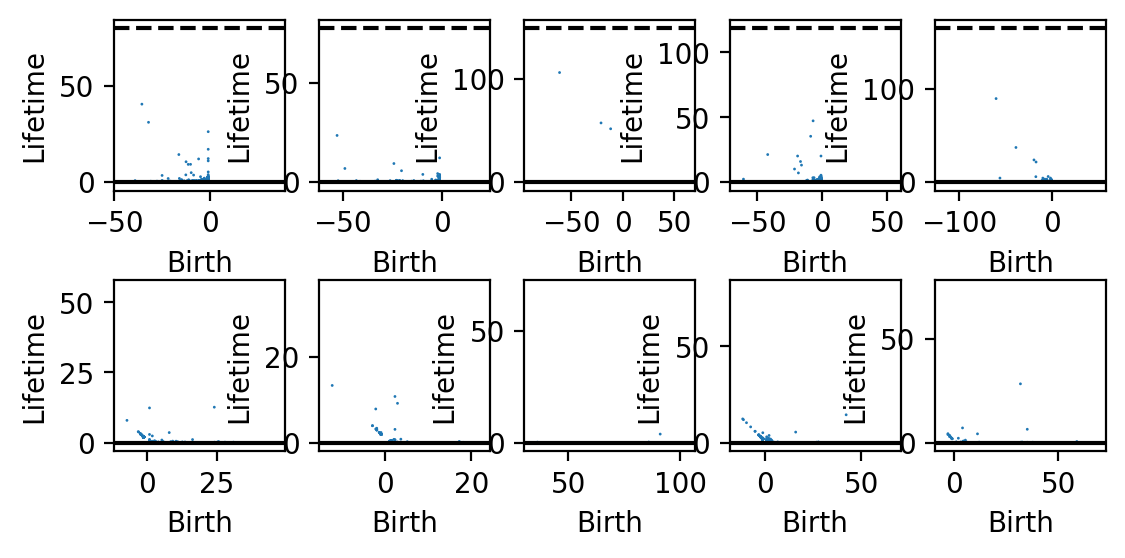

In [13]:
plotPD([0,1,2,3,4],axis=True)

In [57]:
#%% compute persistence image
h=10
max_life=100
m,M=-50,50
sigma = 200.0
clip = False
pim = persim.PersistenceImager(birth_range=(m,M), pers_range=(0,max_life),pixel_size=(M-m)/h,kernel_params={'sigma': [[sigma, 0.0], [0.0, sigma]]})
#pim = persim.PersImage(pixels=[h,h], spread=spread, specs={"minBD": m, "maxBD": M})

# birth-lifetime format
pds_b_l = []
for d in [0,1]:
    pds_b_l.append([])   
    for i in range(len(df_org)):
        pds = df_org.loc[i,'ph']
        p = (pds[pds[:,0]==d])[:,1:3]
        life = p[:,1]-p[:,0]
        if clip:
            life = np.clip(life,a_min=None,a_max=max_life)
    #        p = np.clip(p,a_min=m,a_max=None) # lower clip
        p[:,1] = life
        pds_b_l[d].append(p)
        
pims =[]
for d in [0,1]:
    print("Computing for dimension: ",d)
#    pim = pervect.PersistenceVectorizer().fit(pds_b_l[d])
    with ThreadPoolExecutor(num_cores) as e:
        ret = list(tqdm(e.map(pim.transform, pds_b_l[d]), total=len(df_org)))
    pims.append(ret)

Computing for dimension:  0


  0%|          | 0/21 [00:00<?, ?it/s]

Computing for dimension:  1


  0%|          | 0/21 [00:00<?, ?it/s]

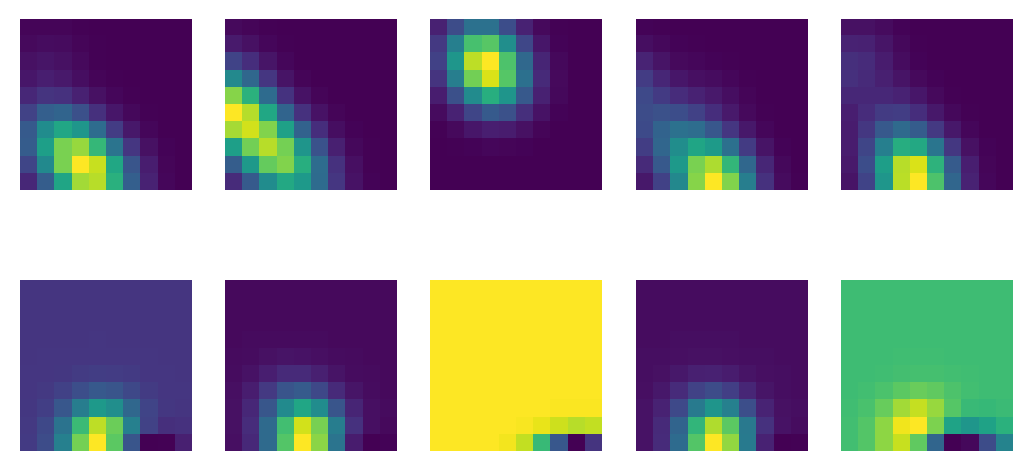

In [65]:
plotPI([0,1,2,3,4])

In [67]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

i,d = 4,1
pd = df_org.loc[i,'ph']
#pd[pd[:,0]==d,1:3]
np.sqrt(np.abs(pims[d][i]))


array([[0.216, 0.202, 0.146, 0.082, 0.036, 0.013, 0.003, 0.001, 0.   ,
        0.   ],
       [0.511, 0.488, 0.356, 0.202, 0.089, 0.031, 0.008, 0.002, 0.   ,
        0.   ],
       [0.911, 0.913, 0.68 , 0.389, 0.173, 0.06 , 0.016, 0.004, 0.001,
        0.   ],
       [1.151, 1.301, 1.008, 0.586, 0.263, 0.092, 0.025, 0.005, 0.001,
        0.   ],
       [0.625, 1.351, 1.144, 0.687, 0.312, 0.11 , 0.03 , 0.006, 0.001,
        0.   ],
       [1.467, 0.815, 0.963, 0.62 , 0.289, 0.103, 0.028, 0.006, 0.001,
        0.   ],
       [2.016, 0.803, 0.519, 0.418, 0.206, 0.075, 0.021, 0.004, 0.001,
        0.   ],
       [1.987, 0.991, 0.281, 0.183, 0.109, 0.042, 0.012, 0.003, 0.   ,
        0.   ],
       [1.644, 0.813, 0.331, 0.084, 0.033, 0.017, 0.005, 0.001, 0.   ,
        0.   ],
       [1.191, 0.555, 0.235, 0.085, 0.023, 0.003, 0.001, 0.   , 0.   ,
        0.   ]])